## CartPole Game Using All Methods 

## 1. Random Policy 
## 2. SARSA
## 3. REINFORCE 
## 4. DQN

In [1]:
pip install gymnasium[box2d] gymnasium pygame numpy torch matplotlib tqdm streamlit==1.24.0

Defaulting to user installation because normal site-packages is not writeable
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached swig-4.4.0-py3-none-win_amd64.whl.metadata (3.5 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.9 MB 2.8 MB/s eta 0:00:03
   -------- ------------------------------- 1.8/8.9 MB 3.5 MB/s eta 0:00:03
   --------- ------------------------------ 2.1/8.9 MB 3.4 MB/s eta 0:00:02
   ------------ --------------------------- 2.9/8.9 MB 3.0 MB/s eta 0:00:03
   ---------------- ----------------------- 3.7/8.9 MB 3.1 MB/s eta 0:00:02
   -------------------- ------------------- 4.5/8.9 MB 3.3 MB/s eta 0:00:02
   ------------------------ --------------- 5.5/8.9 MB 3.5 MB/s eta 0:00:01
   --------------------------------- 

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [16 lines of output]
  Using setuptools (version 75.1.0).
  C:\ProgramData\anaconda3\Lib\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
    warnings.warn(msg)
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-312\Box2D
  copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-312\Box2D
  copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-312\Box2D
  creating build\lib.win-amd64-cpython-312\Box2D\b2
  copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-312\Box2D\b2
  running build_ext
  building 'Box2D._Box2D' extension
  swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
  swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp 

In [2]:

import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import os
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)


## Random policy

In [3]:

def run_random_policy(env_name="CartPole-v1", episodes=100):
    env = gym.make(env_name, render_mode=None)
    rewards = []
    for ep in range(episodes):
        obs, _ = env.reset(seed=seed+ep)
        done = False
        total = 0
        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        rewards.append(total)
    env.close()
    return rewards

# quick test
rand_rewards = run_random_policy(episodes=50)
print("Random policy mean:", np.mean(rand_rewards))


Random policy mean: 21.0


## SARSA (tabular) with state discretization

In [5]:
import gymnasium as gym
import numpy as np
import random
from tqdm import trange

class Discretizer:
    def __init__(self, low, high, bins=(6,12,6,12)):
        self.bins = bins
        self.low = low
        self.high = high
        self.width = (high - low) / np.array(bins)

    def transform(self, obs):
        ratios = (obs - self.low) / self.width
        discrete = np.clip(ratios.astype(int), 0, np.array(self.bins) - 1)
        return tuple(discrete)

def train_sarsa(env_name="CartPole-v1", episodes=2000, alpha=0.1, gamma=0.99, eps=0.1):
    env = gym.make(env_name)
    
    low = np.array([-4.8, -5, -0.418, -5])
    high = np.array([4.8, 5, 0.418, 5])

    disc = Discretizer(low, high, bins=(6,12,6,12))
    
    Q = np.zeros(disc.bins + (env.action_space.n,))
    rewards = []

    seed = 42

    for ep in trange(episodes):
        obs, _ = env.reset(seed=seed + ep)
        s = disc.transform(np.clip(obs, low, high))

        # epsilon-greedy action
        if random.random() < eps:
            a = env.action_space.sample()
        else:
            a = int(np.argmax(Q[s]))

        total = 0
        done = False

        while not done:
            obs2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total += r

            s2 = disc.transform(np.clip(obs2, low, high))

            # next action
            if random.random() < eps:
                a2 = env.action_space.sample()
            else:
                a2 = int(np.argmax(Q[s2]))

            # SARSA update
            Q[s + (a,)] += alpha * (r + gamma * Q[s2 + (a2,)] * (not done) - Q[s + (a,)])

            s, a = s2, a2

        rewards.append(total)

    env.close()
    return Q, rewards

# run training
Q_sarsa, sarsa_rewards = train_sarsa(episodes=1500)
print("SARSA mean (last 100):", np.mean(sarsa_rewards[-100:]))




100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:05<00:00, 259.75it/s]

SARSA mean (last 100): 82.76


##  REINFORCE (Policy Gradient) — PyTorch

In [6]:
# cell 4
class PolicyNet(nn.Module):
    def __init__(self, s_dim=4, a_dim=2, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, a_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.net(x)

def train_reinforce(env_name="CartPole-v1", episodes=2000, gamma=0.99, lr=1e-3):
    env = gym.make(env_name)
    device = torch.device("cpu")
    policy = PolicyNet().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    rewards_history = []
    for ep in trange(episodes):
        obs, _ = env.reset(seed=seed+ep)
        states = []
        actions = []
        rewards = []
        done = False
        while not done:
            state_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            probs = policy(state_t).detach().numpy()[0]
            a = np.random.choice(len(probs), p=probs)
            obs2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            states.append(state_t)
            actions.append(a)
            rewards.append(r)
            obs = obs2
        # compute returns
        G = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            G.insert(0, R)
        G = torch.tensor(G, dtype=torch.float32)
        # normalize rewards
        G = (G - G.mean()) / (G.std() + 1e-9)
        optimizer.zero_grad()
        loss = 0
        for st, a, g in zip(states, actions, G):
            probs = policy(st)
            logp = torch.log(probs[0, a] + 1e-9)
            loss -= logp * g
        loss.backward()
        optimizer.step()
        rewards_history.append(sum(rewards))
    env.close()
    return policy, rewards_history

policy_rg, rg_rewards = train_reinforce(episodes=1200, lr=1e-3)
print("REINFORCE mean (last 100):", np.mean(rg_rewards[-100:]))


100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [05:38<00:00,  3.55it/s]

REINFORCE mean (last 100): 484.19


## DQN (PyTorch, experience replay, target network)

In [7]:
# cell 5
Transition = namedtuple('Transition', ('s', 'a', 'r', 's2', 'done'))

class DQNNet(nn.Module):
    def __init__(self, s_dim=4, a_dim=2, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, a_dim)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

def train_dqn(env_name="CartPole-v1", episodes=800, batch_size=64, gamma=0.99, lr=1e-3,
              buffer_capacity=50000, eps_start=1.0, eps_end=0.01, eps_decay=500):
    env = gym.make(env_name)
    device = torch.device("cpu")
    net = DQNNet().to(device)
    target = DQNNet().to(device)
    target.load_state_dict(net.state_dict())
    opt = optim.Adam(net.parameters(), lr=lr)
    buf = ReplayBuffer(buffer_capacity)
    steps = 0
    rewards = []
    for ep in trange(episodes):
        obs, _ = env.reset(seed=seed+ep)
        total = 0
        done = False
        while not done:
            eps = eps_end + (eps_start - eps_end) * np.exp(-1.0 * steps / eps_decay)
            if random.random() < eps:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    q = net(torch.tensor(obs, dtype=torch.float32).unsqueeze(0)).numpy()[0]
                a = int(np.argmax(q))
            obs2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            buf.push(obs, a, r, obs2, done)
            obs = obs2
            total += r
            steps += 1
            # learn
            if len(buf) >= batch_size:
                batch = buf.sample(batch_size)
                s = torch.tensor(np.vstack(batch.s), dtype=torch.float32)
                a_b = torch.tensor(batch.a, dtype=torch.int64).unsqueeze(1)
                r_b = torch.tensor(batch.r, dtype=torch.float32).unsqueeze(1)
                s2 = torch.tensor(np.vstack(batch.s2), dtype=torch.float32)
                done_b = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1)
                q_vals = net(s).gather(1, a_b)
                with torch.no_grad():
                    q_next = target(s2).max(1)[0].unsqueeze(1)
                    q_target = r_b + gamma * q_next * (1 - done_b)
                loss = nn.MSELoss()(q_vals, q_target)
                opt.zero_grad(); loss.backward(); opt.step()
            # update target
            if steps % 500 == 0:
                target.load_state_dict(net.state_dict())
        rewards.append(total)
    env.close()
    return net, rewards

dqn_net, dqn_rewards = train_dqn(episodes=800)
print("DQN mean (last 100):", np.mean(dqn_rewards[-100:]))


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [14:45<00:00,  1.11s/it]

DQN mean (last 100): 458.71


## Evaluation & comparison (plotting)

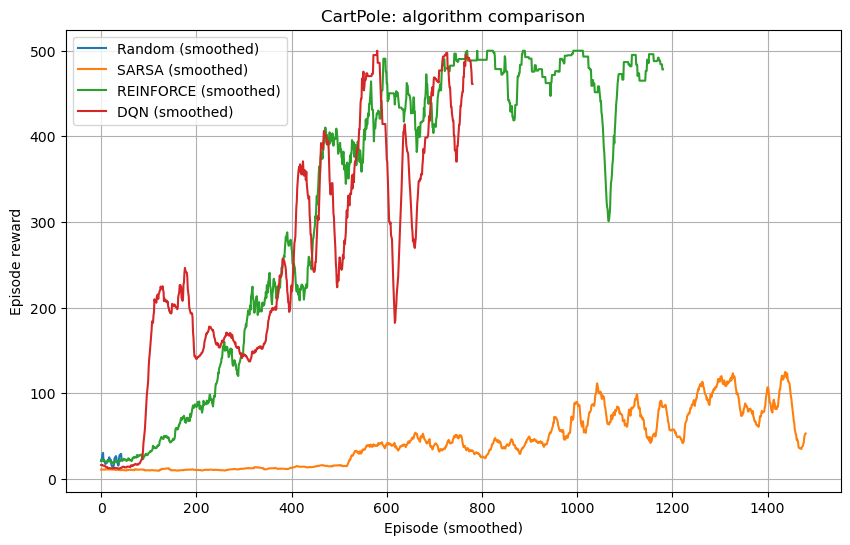

,method,mean_last_100
0,Random,21.00
1,SARSA,82.76
2,REINFORCE,484.19
3,DQN,458.71


In [8]:
# cell 6
import pandas as pd

def smooth(x, window=20):
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,6))
plt.plot(smooth(rand_rewards, 5), label='Random (smoothed)')
plt.plot(smooth(sarsa_rewards, 20), label='SARSA (smoothed)')
plt.plot(smooth(rg_rewards, 20), label='REINFORCE (smoothed)')
plt.plot(smooth(dqn_rewards, 20), label='DQN (smoothed)')
plt.xlabel("Episode (smoothed)")
plt.ylabel("Episode reward")
plt.legend()
plt.title("CartPole: algorithm comparison")
plt.grid(True)
plt.show()

# summary table
summary = pd.DataFrame({
    'method':['Random','SARSA','REINFORCE','DQN'],
    'mean_last_100':[np.mean(rand_rewards[-100:]) if len(rand_rewards)>=100 else np.mean(rand_rewards),
                     np.mean(sarsa_rewards[-100:]),
                     np.mean(rg_rewards[-100:]),
                     np.mean(dqn_rewards[-100:])]
})
summary


## Save/Load models



In [10]:

os.makedirs("models", exist_ok=True)
torch.save(policy_rg.state_dict(), "models/reinforce_policy.pth")
torch.save(dqn_net.state_dict(), "models/dqn_net.pth")
# For SARSA Q you can np.save:
np.save("models/sarsa_Q.npy", Q_sarsa)


## 🔵 Why SARSA beats Random but lags behind DQN/REINFORCE?

Tabular SARSA discretization use karta hai, so information loss hoti hai

DQN / REINFORCE continuous state ko neural networks se handle karte hai

Isi liye DQN aur REINFORCE top performers hote hain